In [1]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

NOTEBOOK_PATH = os.getcwd()

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(NOTEBOOK_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings("ignore")

### Classification

**Build a classification model for the default of credit card clients dataset.**

More info here: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The process and questions you need to think about while coding (you should write your response at the cell in the end part of the notebook)

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one we used in classification notebook.
- Study the ROC Curve, decide threshold
- Use 2 classifiers and cross-validation with 5-folds.
    - Random Forest
        - tune only: n_estimators: {4, 5, 10, 20, 50} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 5, 10, 20} 
    - For other paramenters, use default
- Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html



In [2]:
df = pd.read_excel("datasets/default of credit card clients.xls", skiprows= 1, header = 0)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.shape

(30000, 25)

In [4]:
df.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [5]:
df=df.replace('?',np.nan)
print('Number of instances=%d'%(df.shape[0]))
print('Number of attributes=%d'%(df.shape[1]))

print('Number pf missing values:')

for column in df.columns:
    print('\t%s: %d'%(column,df[column].isna().sum()))

Number of instances=30000
Number of attributes=25
Number pf missing values:
	ID: 0
	LIMIT_BAL: 0
	SEX: 0
	EDUCATION: 0
	MARRIAGE: 0
	AGE: 0
	PAY_0: 0
	PAY_2: 0
	PAY_3: 0
	PAY_4: 0
	PAY_5: 0
	PAY_6: 0
	BILL_AMT1: 0
	BILL_AMT2: 0
	BILL_AMT3: 0
	BILL_AMT4: 0
	BILL_AMT5: 0
	BILL_AMT6: 0
	PAY_AMT1: 0
	PAY_AMT2: 0
	PAY_AMT3: 0
	PAY_AMT4: 0
	PAY_AMT5: 0
	PAY_AMT6: 0
	default payment next month: 0


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
dep_var = ['default payment next month']

categorical_vars = ['PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5', 'PAY_6','SEX','MARRIAGE','EDUCATION']

discrete_vars = ['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4',
                 'BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

continuous_vars = ['AGE']

In [8]:
df.loc[:, dep_var + discrete_vars + continuous_vars].describe()

,default payment next month,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.221200,167484.322667,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,35.485500
std,0.415062,129747.661567,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,9.217904
min,0.000000,10000.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,21.000000
25%,0.000000,50000.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,28.000000
50%,0.000000,140000.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,34.000000
75%,0.000000,240000.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,41.000000
max,1.000000,1000000.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,79.000000


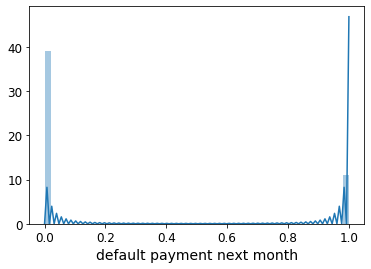

In [9]:
sns.distplot(df['default payment next month'])

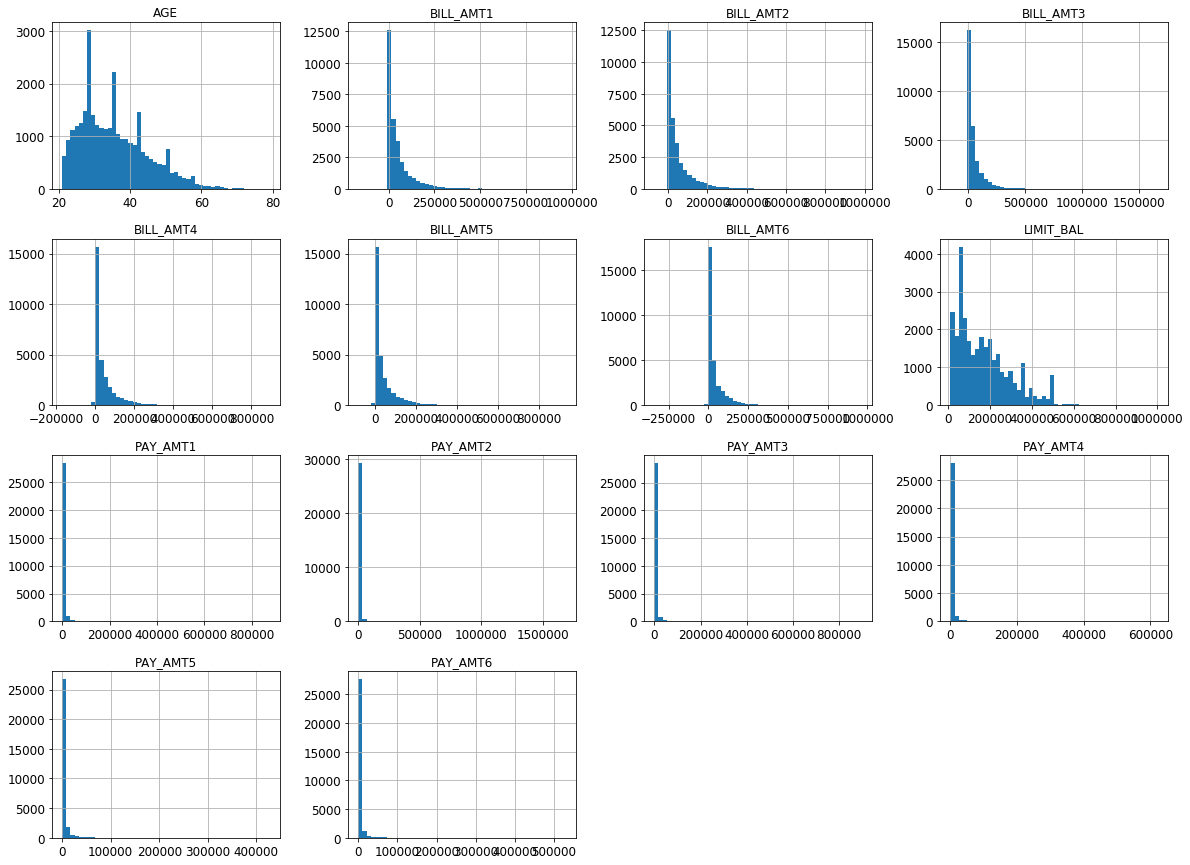

In [10]:
df.loc[:, discrete_vars + continuous_vars].hist(bins=50, figsize=(20,15))
plt.show()

### Correlation Analysis

In [11]:
corr_matrix = df.loc[:, ['default payment next month'] + discrete_vars].corr(method='pearson')
corr_matrix['default payment next month'].sort_values(ascending=False)
corr_matrix

,default payment next month,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
default payment next month,1.000000,-0.153520,-0.019644,-0.014193,-0.014076,-0.010156,-0.006760,-0.005372,-0.072929,-0.058579,-0.056250,-0.056827,-0.055124,-0.053183
LIMIT_BAL,-0.153520,1.000000,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595
BILL_AMT1,-0.019644,0.285430,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341
BILL_AMT2,-0.014193,0.278314,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594,0.280365,0.100851,0.150718,0.147398,0.157957,0.174256
BILL_AMT3,-0.014076,0.283236,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320,0.244335,0.316936,0.130011,0.143405,0.179712,0.182326
BILL_AMT4,-0.010156,0.293988,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941,0.233012,0.207564,0.300023,0.130191,0.160433,0.177637
BILL_AMT5,-0.006760,0.295562,0.829779,0.859778,0.883910,0.940134,1.000000,0.946197,0.217031,0.181246,0.252305,0.293118,0.141574,0.164184
BILL_AMT6,-0.005372,0.290389,0.802650,0.831594,0.853320,0.900941,0.946197,1.000000,0.199965,0.172663,0.233770,0.250237,0.307729,0.115494
PAY_AMT1,-0.072929,0.195236,0.140277,0.280365,0.244335,0.233012,0.217031,0.199965,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735
PAY_AMT2,-0.058579,0.178408,0.099355,0.100851,0.316936,0.207564,0.181246,0.172663,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634


Text(0.5, 1, 'Pearsons Correlation Factors Heat Map')

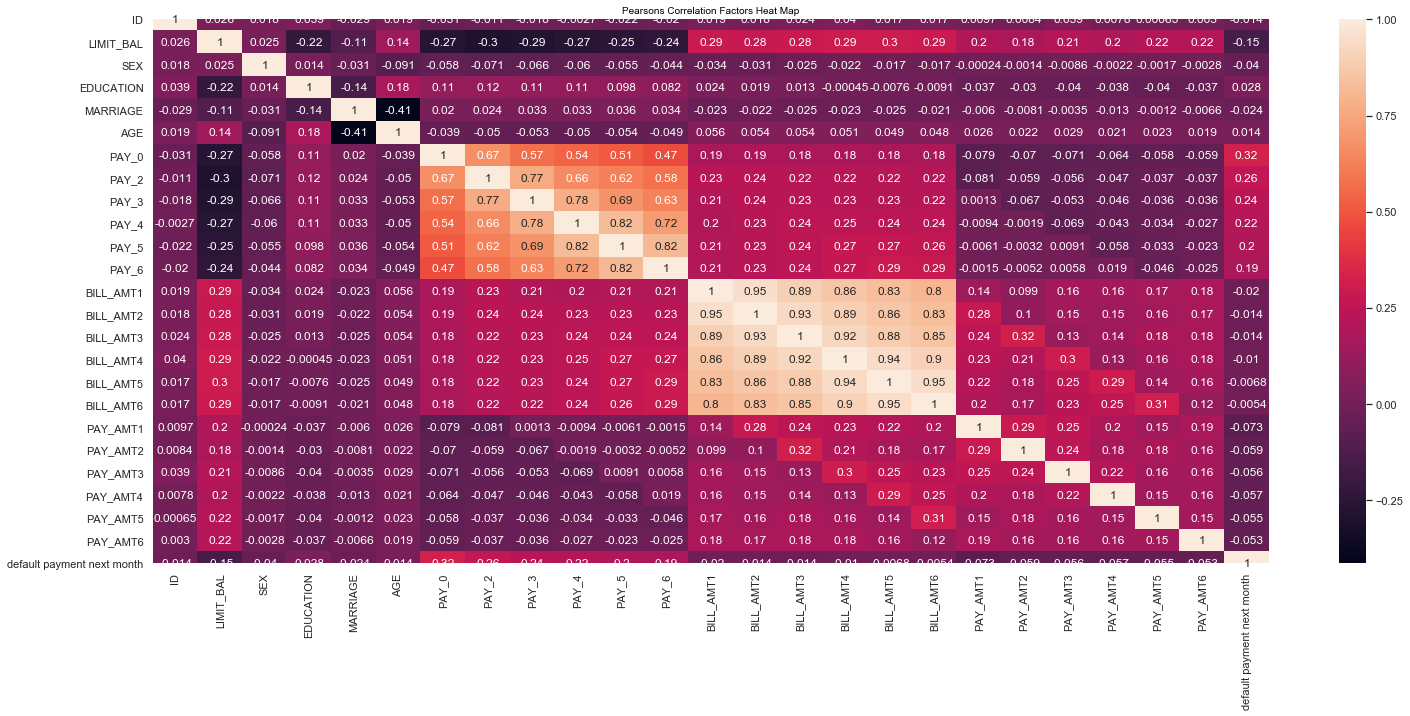

In [16]:
corr = df.corr() #saving the correlation for later use
ax = sns.set(rc={'figure.figsize':(25,10)})
sns.heatmap(corr, annot=True).set_title('Pearsons Correlation Factors Heat Map', color='black', size='10')

### Pre Processing

In [17]:
print(df[['BILL_AMT4']].values[:, 0])
tfmr = SimpleImputer(strategy='median')
print(tfmr.fit_transform(df[['BILL_AMT4']].values)[:, 0])

print(df[['BILL_AMT5']].values[:, 0])
tfmr = SimpleImputer(strategy='median')
print(tfmr.fit_transform(df[['BILL_AMT5']].values)[:, 0])

print(df[['BILL_AMT6']].values[:, 0])
tfmr = SimpleImputer(strategy='median')
print(tfmr.fit_transform(df[['BILL_AMT6']].values)[:, 0])



[    0  3272 14331 ... 20878 52774 36535]
[    0.  3272. 14331. ... 20878. 52774. 36535.]
[    0  3455 14948 ... 20582 11855 32428]
[    0.  3455. 14948. ... 20582. 11855. 32428.]
[    0  3261 15549 ... 19357 48944 15313]
[    0.  3261. 15549. ... 19357. 48944. 15313.]


In [18]:
print(df[['LIMIT_BAL']].values[:, 0])
tfmr = MinMaxScaler()
print(tfmr.fit_transform(df[['LIMIT_BAL']].values)[:, 0])

print(df[['PAY_AMT1']].values[:, 0])
tfmr = MinMaxScaler()
print(tfmr.fit_transform(df[['PAY_AMT1']].values)[:, 0])

print(df[['PAY_AMT2']].values[:, 0])
tfmr = MinMaxScaler()
print(tfmr.fit_transform(df[['PAY_AMT2']].values)[:, 0])

print(df[['PAY_AMT3']].values[:, 0])
tfmr = MinMaxScaler()
print(tfmr.fit_transform(df[['PAY_AMT3']].values)[:, 0])

print(df[['PAY_AMT4']].values[:, 0])
tfmr = MinMaxScaler()
print(tfmr.fit_transform(df[['PAY_AMT4']].values)[:, 0])

print(df[['PAY_AMT5']].values[:, 0])
tfmr = MinMaxScaler()
print(tfmr.fit_transform(df[['PAY_AMT5']].values)[:, 0])

print(df[['PAY_AMT6']].values[:, 0])
tfmr = MinMaxScaler()
print(tfmr.fit_transform(df[['PAY_AMT6']].values)[:, 0])

# NOTE: if you get a DataConversionWarning you can safely ignore it.

[ 20000 120000  90000 ...  30000  80000  50000]
[0.01010101 0.11111111 0.08080808 ... 0.02020202 0.07070707 0.04040404]
[    0     0  1518 ...     0 85900  2078]
[0.         0.         0.00173773 ... 0.         0.09833416 0.00237879]
[ 689 1000 1500 ...    0 3409 1800]
[0.00040908 0.00059373 0.0008906  ... 0.         0.00202404 0.00106872]
[    0  1000  1000 ... 22000  1178  1430]
[0.         0.00111602 0.00111602 ... 0.02455248 0.00131467 0.00159591]
[   0 1000 1000 ... 4200 1926 1000]
[0.         0.00161031 0.00161031 ... 0.00676329 0.00310145 0.00161031]
[    0     0  1000 ...  2000 52964  1000]
[0.         0.         0.00234451 ... 0.00468901 0.12417444 0.00234451]
[   0 2000 5000 ... 3100 1804 1000]
[0.         0.00378311 0.00945777 ... 0.00586382 0.00341236 0.00189155]


### Pipelining Transformers

In [19]:

# Numerical - impute, scale
num_si_step = ('si', SimpleImputer(strategy='median'))
num_scl_step = ('scl', MinMaxScaler())
num_steps = [num_si_step, num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, discrete_vars + continuous_vars+categorical_vars)]

In [20]:
ct = ColumnTransformer(transformers= num_transformers)
ct.fit(df[categorical_vars + discrete_vars + continuous_vars])
X = ct.transform(df[ categorical_vars +discrete_vars + continuous_vars])
# We know from our exploration that the dependent variable 'price' does not have any missing values. 
# It is also generally not neccessary to apply transformations to normalize or scale
# the dependent variable.
y = df[['default payment next month']].values

In [21]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

In [22]:
#Splitting it into train and test dataset
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = 0.2,random_state = 123) 
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)# Splitting it into 400 train and 100 test data set

(24000, 24) (24000,) (6000, 24) (6000,)


## RandomForestClassifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

n_estimators = [4, 5, 10, 20, 50]  

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, Y_train)
    y_probas_forest = cross_val_predict(rf, X_train, Y_train, cv=5, method="predict_proba")
    y_probas_forest

In [24]:
y_train_rf_pred = cross_val_predict(rf, X_train, Y_train, cv=5)


In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, y_train_rf_pred)

0.81525

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(Y_train, y_train_rf_pred )

0.6513823331085637

In [27]:
recall_score(Y_train, y_train_rf_pred )

0.3623405851462866

In [28]:
from sklearn.metrics import f1_score
f1_score(Y_train, y_train_rf_pred, average="macro")

0.6769861717080754

In [29]:
from sklearn.metrics import roc_curve

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr, tpr, thresholds_forest = roc_curve(Y_train,y_scores_forest)

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(Y_train, y_scores_forest)

0.0
Saving figure precision_recall_vs_threshold_plot


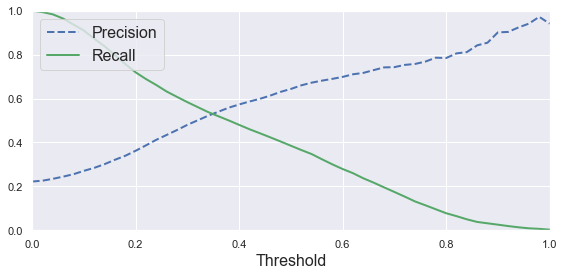

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
print(min(thresholds))
plt.xlim([min(thresholds), max(thresholds)])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


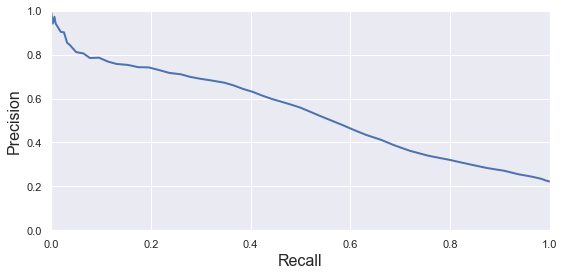

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Saving figure roc_curve_plot


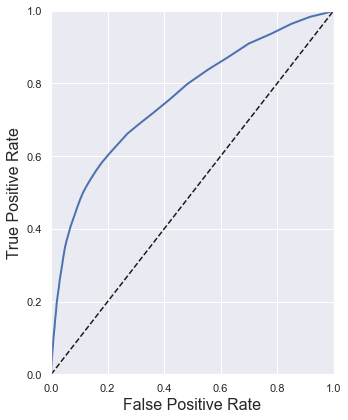

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(5, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_train, y_scores_forest)

0.7593299402228959

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [4, 5, 10, 20, 50]}]

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    5.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [36]:
grid_search_rf.best_params_

{'n_estimators': 50}

In [37]:
grid_search_rf.best_score_

0.8165833333333333

In [38]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.8148333333333333

## KNeighborsClassifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

neighbors = [3, 5, 10, 20]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    y_probas_knn = cross_val_predict(knn, X_train, Y_train, cv=5,
                                    method="predict_proba")

In [40]:
y_train_knn_pred = cross_val_predict(knn, X_train, Y_train, cv=5)

In [41]:
from sklearn.metrics import accuracy_score


accuracy_score(Y_train, y_train_knn_pred)


0.7750416666666666

In [42]:

f1_score(Y_train, y_train_knn_pred, average="macro")

0.4845571428907278

In [43]:
precision_score(Y_train, y_train_knn_pred)

0.4485407066052227

In [44]:
recall_score(Y_train, y_train_knn_pred)

0.05476369092273068

### ROC Curve

In [45]:
from sklearn.metrics import roc_curve

y_scores_knn = y_probas_knn[:, 1] # score = proba of positive class
fpr_knn, tpr_knn, thresholds_forest = roc_curve(Y_train,y_scores_knn)

Saving figure roc_curve_plot


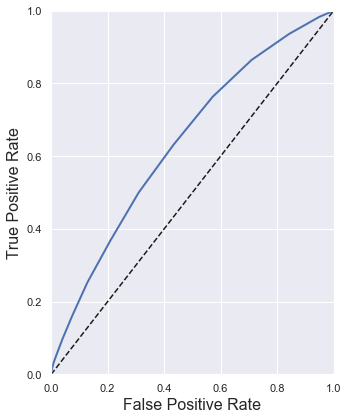

In [46]:
def plot_roc_curve(fpr_knn, tpr_knn, label=None):
    plt.plot(fpr_knn, tpr_knn, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(5, 6))
plot_roc_curve(fpr_knn, tpr_knn)
save_fig("roc_curve_plot")
plt.show()

Saving figure roc_curve_comparison_plot


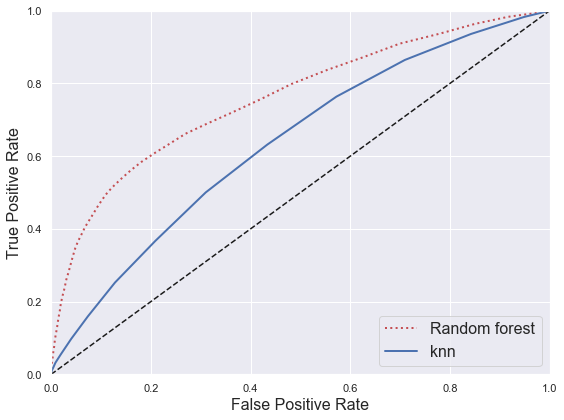

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "r:", linewidth=2, label="Random forest")
plot_roc_curve(fpr_knn, tpr_knn, "knn")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [48]:
roc_auc_score(Y_train, y_scores_knn)

0.637527083184981

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = [{ 'n_neighbors': [3, 5, 10, 20]}]

knn_clf = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search_knn.fit(X_train, Y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 5, 10, 20]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [50]:
grid_search_knn.best_params_

{'n_neighbors': 20}

In [51]:
grid_search_knn.best_score_

0.7750416666666666

In [52]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_knn.predict(X_test)
accuracy_score(Y_test, y_pred)


0.783

#### CONCLUSIONS

**Q1. Explain your results, choices and responses to all of the questions at the begining of the notebook.**

<pre>

 1) Data expoloration
     The dataset contains 30k entities, 25 attributes
     Checked the missing values - no missing values in this dataset
     The data values are all numerical
     The dataset contains values that are of different ranges
         -The range of the values are from 0 to 10k.
         -There are negative values too
     So the data must be processed- Normalized. 
 2) Data Preprocessing
      Normalization of the data values 
          -The values of numeric columns in the dataset to a common scale.
      Correlation Analysis
          -Used pearsons correlation 
          -Correlation between the features is no more than 0.95, so we decided to use all attriblutes.
 3) Splitting data  
        - training (80%) and testing (20%)
 4) Model Fitting 
        - ROC curve analysis
              Analysing the ROC curve also assures that Random forest has high score.The precision, 
              recall score for Random is way more high compared to KNeighbors
        - Which one performs better in the cross validation?
             For Random Forest the accuracy score is 0.8157 and 
             For KNeighbors Classifier the accuracy score is 0.77. 
             The best model that fits to train the Default of credit card dataset is RandomForest Classifier. 
             The best tuning metric value is 50 for RandomForest and for KNeighbors it is 20. 
 </pre>

Q2. (Optional: 10% Extra Credit) Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

_Note: It may make the training/text process to take several hours!_

In [53]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [54]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [55]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [56]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [57]:
from scipy.ndimage.interpolation import shift

Saving figure some_digit_plot


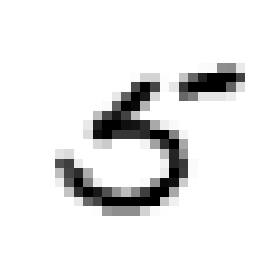

In [58]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[335]
image = some_digit.reshape(28, 28)
plt.imshow(image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

import os
os.getcwd()

save_fig("some_digit_plot")
plt.show()

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [60]:
y_knn_pred = knn_clf.predict(X_test)

In [61]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

In [62]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

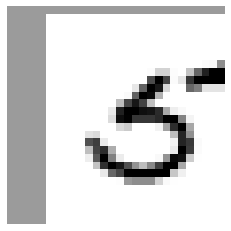

In [64]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

### Shift image by one pixel

In [65]:
X_tr_extend= [X_train]
y_tr_expand = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_tr_extend.append(shifted_images)
    y_tr_expand.append(y_train)

X_tr_extend = np.concatenate(X_tr_extend)
y_tr_expand = np.concatenate(y_tr_exptend)
X_tr_extend.shape, y_tr_expand.shape

((300000, 784), (300000,))

In [66]:
knn_clf.fit(X_tr_extend, y_tr_expand)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [67]:
y_knn_expand_pred = knn_clf.predict(X_test)

In [68]:
accuracy_score(y_test, y_knn_expand_pred)

0.9763

In [69]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

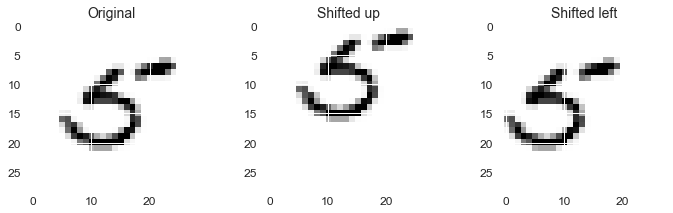

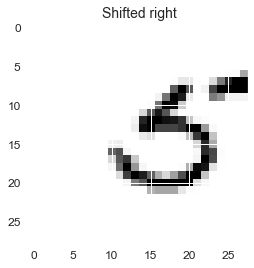

In [70]:
shifted_image_up = shift_image(image, 0, -5)
shifted_image_left = shift_image(image, -5, 0)
shifted_image_right = shift_image(image,+5,0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted up", fontsize=14)
plt.imshow(shifted_image_up.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()
plt.title("Shifted right", fontsize=14)
plt.imshow(shifted_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()


## KNeighbors Classifier

In [71]:
X_tr_augment = [image for image in X_train]
y_tr_augment = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_tr_augment.append(shift_image(image, dx, dy))
        y_tr_augment.append(label)

X_tr_augment = np.array(X_tr_augment)
y_tr_augment = np.array(y_tr_augment)

In [72]:
shuffle_idx = np.random.permutation(len(X_tr_augment))
X_tr_augment = X_tr_augment[shuffle_idx]
y_tr_augment= y_tr_augment[shuffle_idx]

In [73]:
knn_clf1 = KNeighborsClassifier(n_jobs=-1, n_neighbors=4)

In [74]:
knn_clf1.fit(X_tr_augment, y_tr_augment)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='uniform')

In [75]:
y_pred = knn_clf1.predict(X_test)
accuracy_score(y_test, y_pred)

0.9756

## RandomForest Claasifier

In [76]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42,n_estimators=10)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [77]:
y_forest_pred = forest_clf.predict(X_test)

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_forest_pred)

0.9495

In [79]:
forest_clf.fit(X_tr_augment, y_tr_augment)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [80]:
y_forest_expanded_pred = forest_clf.predict(X_test)

In [81]:
accuracy_score(y_test, y_forest_expanded_pred)

0.9654

## Analysis for the MNIST 

<pre>
The best model that fits this dataset is KNeighbors Classifier with accuracy score of 0.97, this is obtained after train  best model on this expanded training set and measuring its accuracy on the test set.
Augmenting the data has a 0.5% accuracy boost</pre>

### Submit your notebook

Submit your solution on Canvas